# Abstract

The classical view of overfitting posits that increasing the number of features used for training beyond the number of samples will result in very low training error, but poor generalization, as the model perfectly interpolates the training data. However, the rise of deep learning has challenged this view, as using large numbers of features has led to even stronger performances on test data than using features below the interpolation point. In this blog post, we use a linear regression algorithm along with random sigmoidal feature maps to demonstrate the phenomenon of "double descent", where accuracy improves when we pass the interpolation point. The optimal result in terms of mean squared error loss is achieved when using a quantity of features far beyond the interpolation point, showing that using more features than data points does not always lead to overfitting.

# Background
The standard formula for the optimal weight vector in unregularized least-squares linear regression is as follows:

$\hat{w} = \arg\min_{w} \|Xw - y\|^2$

Where X is an ${n} \times {p}$ matrix. This equation has the following closed form solution when ${n} > {p}$:

$\hat{w} = (X^\top X)^{-1} X^\top y$

If ${p} > {n}$, this no longer works because of matrix invertibility. ${X}$ is ${n} \times {p}$, and ${X^\top}$ is ${p} \times {n}$. Multiplying these matrices (the ${X^\top X}$ term) results in a ${p} \times {p}$ matrix. For a matrix to be invertible, it must be full rank, meaning that all rows of the matrix must be linearly independent. If ${X}$ has ${n}$ rows, its maximum rank is ${n}$, since there are only ${n}$ rows. Any matrix built from multiplying ${X}$ by another matrix will be constrained to a maximum rank of ${n}$, since it comes from a matrix with rank <= ${n}$. Therefore, ${X^\top X}$ will generate a ${p} \times {p}$ matrix with rank <= ${n}$, so it will not be invertible, making the solution fail.

To account for this, we will use a different optimization function in our model, which does not fail in the case where ${p}$ > ${n}$.

# Model Implementation
We will be implementing a linear regression model for this demonstration. We will use the previously implemented `LinearModel` class as a base.

In [13]:
import torch
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
class LinearModel:

    def __init__(self):
        self.w = None 

    def score(self, X):
        if self.w is None: 
            self.w = torch.rand((X.size()[1]))
        return X @ self.w 

    def predict(self, X):
        scores = self.score(X)
        return (scores >= 0)

Now we can create the `MyLinearRegression` model, which will inherit from `LinearModel`, with an identical predict method, and a loss function which builds on the predict method. We will use the mean-squared error loss function here.

In [18]:
class MyLinearRegression(LinearModel):

    def predict(self, X):
        return X@self.w

    def loss(self, X, y):
        scores = self.predict(X)
        return torch.mean((scores -y) ** 2)

Lastly, we will implement the optimizer class. Here is where we will use a different optimization function. Instead of using the optimal mean-squared error closed form solution, we will use the Moore-Penrose pseudoinverse of ${X}$. The advantage here is that the Moore-Penrose pseudoinverse function does *not* fail when ${p}$ > ${n}$, meaning we can potentially achieve higher accuracy by using more features than data points.

In [8]:
class OverParameterizedLinearRegressionOptimizer:

    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        self.model.w = torch.linalg.pinv(X)@y

In the experiments on this model, I will use the following functions imported from Phil's notes to generate random sigmoidal feature maps. This will allow us to vary the number of features used in training, so we can observe the change as we pass the interpolation point.

In [11]:
def sig(x): 
    return 1/(1+torch.exp(-x))

def square(x): 
    return x**2

class RandomFeatures:
    """
    Random sigmoidal feature map. This feature map must be "fit" before use, like this: 

    phi = RandomFeatures(n_features = 10)
    phi.fit(X_train)
    X_train_phi = phi.transform(X_train)
    X_test_phi = phi.transform(X_test)

    model.fit(X_train_phi, y_train)
    model.score(X_test_phi, y_test)

    It is important to fit the feature map once on the training set and zero times on the test set. 
    """

    def __init__(self, n_features, activation = sig):
        self.n_features = n_features
        self.u = None
        self.b = None
        self.activation = activation

    def fit(self, X):
        self.u = torch.randn((X.size()[1], self.n_features), dtype = torch.float64)
        self.b = torch.rand((self.n_features), dtype = torch.float64) 

    def transform(self, X):
        return self.activation(X @ self.u + self.b)

# Experiments

We will begin with a simple problem just to be certain that the class is working as intended. The following code block generates some simple data which we can use to test our model.

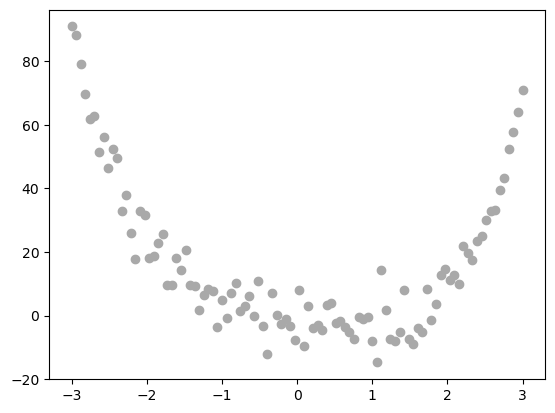

In [10]:
X = torch.tensor(np.linspace(-3, 3, 100).reshape(-1, 1), dtype = torch.float64)
y = X**4 - 4*X + torch.normal(0, 5, size=X.shape)

plt.scatter(X, y, color='darkgrey', label='Data')
plt.show()

Now we will apply a feature map with 100 features, and fit the dataset to our linear regression model. We will then plot the line of best fit predicted by the model, to see if it looks within reason.

In [22]:
phi = RandomFeatures(n_features=100, activation=sig)
phi.fit(X)
X_features = phi.transform(X)

LR = MyLinearRegression()
opt = OverParameterizedLinearRegressionOptimizer(LR)
opt.fit(X_features, y)

y_pred = LR.predict(X_features)
loss = LR.loss(X_features, y)

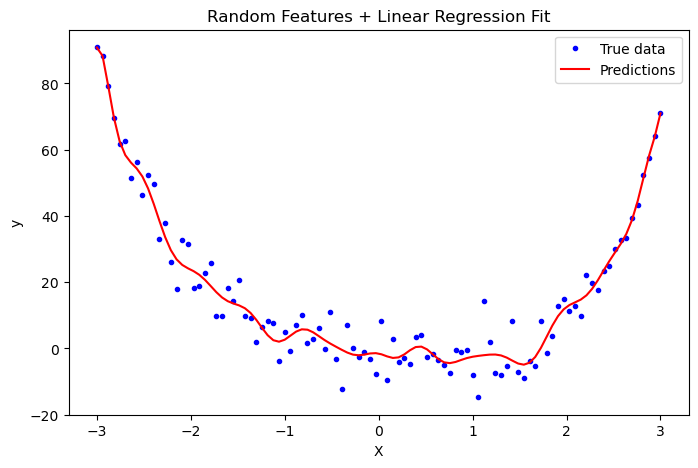

In [23]:
X_np = X.numpy()
y_np = y.numpy()
y_pred_np = y_pred.detach().numpy()

plt.figure(figsize=(8,5))
plt.plot(X_np, y_np, 'b.', label='True data')
plt.plot(X_np, y_pred_np, 'r-', label='Predictions')
plt.legend()
plt.xlabel('X')
plt.ylabel('y')
plt.title('Random Features + Linear Regression Fit')
plt.show()

The model has made a reasonable predicting line, so it seems to be working well despite the different optimization function. We can now move on to demonstrating perfect interpolation and double descent.

# Image Corruption Dataset

To explore this phenomenon, we will work with a set of grayscale images. The following code block (taken from Phil's notes) shows a sample image.

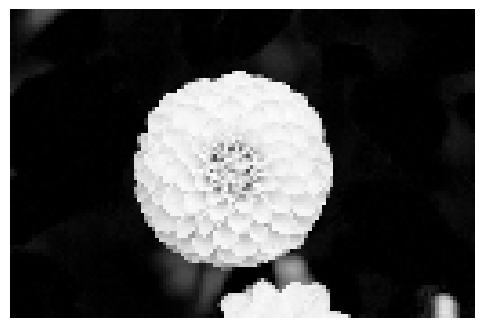

In [27]:
from sklearn.datasets import load_sample_images
from scipy.ndimage import zoom

dataset = load_sample_images()     
X = dataset.images[1]
X = zoom(X,.2) #decimate resolution
X = X.sum(axis = 2)
X = X.max() - X 
X = X / X.max()
flower = torch.tensor(X, dtype = torch.float64)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(flower, cmap='Greys')
off = ax.axis("off")

For our machine learning model, we will add a random, variable amount of corruption to each image in the dataset, represented by blocks of gray pixels. The regression task will be to predict the number of corruptions in the image using only the image itself. The following code block (also taken from Phil's notes) contains the function which adds corruption to the images. We will then generate the dataset, placing variable amounts of corruption in each image, and then flatten each image into a torch tensor. Each entry in the torch tensor represents a single pixel in the image.

In [28]:
def corrupted_image(im, mean_patches = 5): 
    n_pixels = im.size()
    num_pixels_to_corrupt = torch.round(mean_patches*torch.rand(1))
    num_added = 0

    X = im.clone()

    for _ in torch.arange(num_pixels_to_corrupt.item()): 
        
        try: 
            x = torch.randint(0, n_pixels[0], (2,))

            x = torch.randint(0, n_pixels[0], (1,))
            y = torch.randint(0, n_pixels[1], (1,))

            s = torch.randint(5, 10, (1,))
            
            patch = torch.zeros((s.item(), s.item()), dtype = torch.float64) + 0.5

            # place patch in base image X
            X[x:x+s.item(), y:y+s.item()] = patch
            num_added += 1

            
        except: 
            pass

    return X, num_added

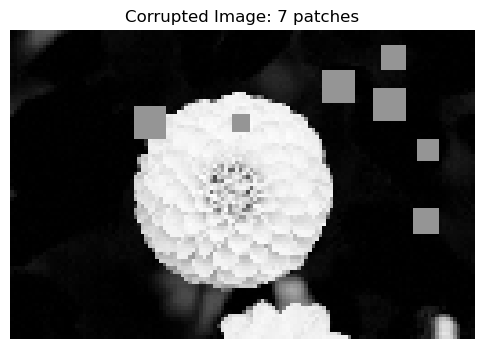

In [30]:
X, y = corrupted_image(flower, mean_patches = 50)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(X.numpy(), vmin = 0, vmax = 1, cmap='Greys')
ax.set(title = f"Corrupted Image: {y} patches")
off = plt.gca().axis("off")

In [31]:
n_samples = 200

X = torch.zeros((n_samples, flower.size()[0], flower.size()[1]), dtype = torch.float64)
y = torch.zeros(n_samples, dtype = torch.float64)
for i in range(n_samples): 
    X[i], y[i] = corrupted_image(flower, mean_patches = 100)

As a final preparatory step, we will also perform a train test split so we can see how the interpolation phenomenon operates on training and testing data.

In [33]:
from sklearn.model_selection import train_test_split

X = X.reshape(n_samples, -1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

Now we have a working dataset, and can fit our model. To accomplish this, we use an iterative approach, applying a feature map to the dataset at each step, with a slowly increasing number of features. I found that using a range from 0 to 300 in steps of 2 features worked best for visualization purposes. At each iteration, we will apply the feature map, though we only call `phi.fit` on the training dataset, so the testing dataset remains untouched. We then fit the linear regression, compute the loss, and store the result in a list so we can visualize the change as we vary the number of features.

In [61]:
feature_counts = list(range(0, 301, 2)) # try feature counts from 0 to 300 (steps of 2 for graph clarity)
losses_train = []
losses_test = []

for n_features in feature_counts: 
    phi = RandomFeatures(n_features=n_features, activation=square)
    phi.fit(X_train)
    X_train_phi = phi.transform(X_train)
    X_test_phi = phi.transform(X_test)

    LR = MyLinearRegression()
    opt = OverParameterizedLinearRegressionOptimizer(LR)
    opt.fit(X_train_phi, y_train)

    loss_train = LR.loss(X_train_phi, y_train).item() # .item converts to float
    loss_test = LR.loss(X_test_phi, y_test).item()
    losses_train.append(loss_train)
    losses_test.append(loss_test)

The following code block plots the mean-squared loss values as the number of features used increases. The dashed red line is at `n_features = 100`, which is the interpolation point, where the number of features used surpasses the number of images in the dataset. The minimum loss achieved is also highlighted in green. Also, I used a logarithmic scale to make the visualization more clear, but note that this means the loss values shown on the plots are not exact.

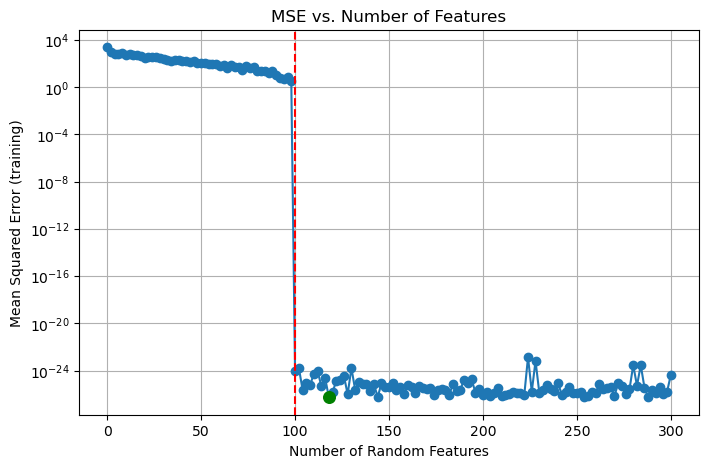

In [62]:
plt.figure(figsize=(8, 5))
plt.plot(feature_counts, losses_train, marker='o')

plt.yscale('log')
plt.axvline(x=100, color='red', linestyle='--', label='x = 100')

min_idx = torch.tensor(losses_train).argmin().item()
min_features = feature_counts[min_idx]
min_loss = losses_train[min_idx]
plt.scatter(min_features, min_loss, color='green', s=70, zorder=5, label='Min Loss')

plt.xlabel("Number of Random Features")
plt.ylabel("Mean Squared Error (training)")
plt.title("MSE vs. Number of Features")
plt.grid(True)
plt.show()

As we can see, there is a dramatic drop in loss at the interpolation point, and the optimal training loss was achieved around `n_features = 120`. To see whether the model fell into overfitting or not, we can now examine the test dataset.

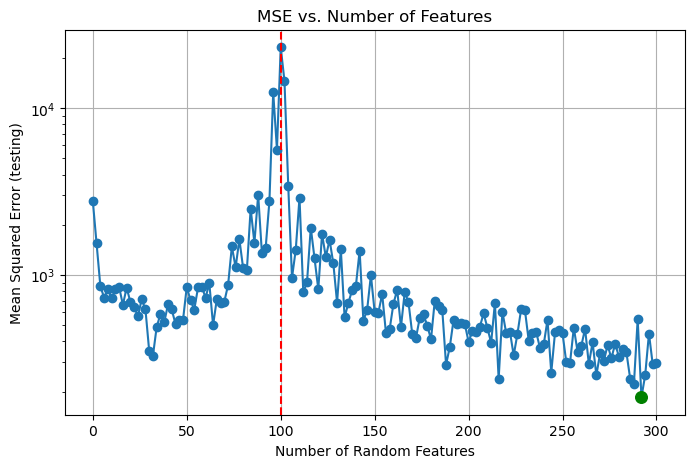

In [63]:
plt.figure(figsize=(8, 5))
plt.plot(feature_counts, losses_test, marker='o')

plt.yscale('log')
plt.axvline(x=100, color='red', linestyle='--', label='x = 100')

min_idx = torch.tensor(losses_test).argmin().item()
min_features = feature_counts[min_idx]
min_loss = losses_test[min_idx]
plt.scatter(min_features, min_loss, color='green', s=70, zorder=5, label='Min Loss')

plt.xlabel("Number of Random Features")
plt.ylabel("Mean Squared Error (testing)")
plt.title("MSE vs. Number of Features")
plt.grid(True)
plt.show()

In [64]:
print("The minimum loss was", min_loss, "achieved using", min_features, "features.")

The minimum loss was 184.91291376461538 achieved using 292 features.


At the interpolation point, the mean-squared loss increases greatly on test data. However, as we use more and more features, the performance actually improves, with the optimal loss being achieved at `n_features = 292`. This is the phenomenon of double descent, where we can achieve better testing performance by using greatly more features than the number of datapoints available, which stands in direct contrast to the classical view of overfitting. This result is what powers deep learning models, which are now overparameterized to extreme extents.

# Discussion

In this blog post, we showed how using certain optimization functions can allow for double descent, which enables the use of overparameterization as a means of improving training performance. Despite the optimal closed-form solution for mean-squared error not working with overparameterization, using the Moore-Penrose pseudoinverse allows overparameterization, which was demonstrated to be highly beneficial. The loss values before the interpolation point were much larger than the loss values after the interpolation point. This has important implications for machine learning, as if we can improve performance by providing more features, then improving the scale of data available to train on will also lead to improved model performance. We also do not have to worry as much about overfitting, which has traditionally been a key challenge in developing highly tuned models.